1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1000
1010
1000
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000
1010
1000
1010
1000
1010
1000
1000
1010
1000


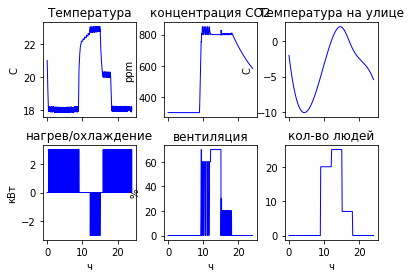

In [82]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# CONTROLLER FUNCTION
def OnOff(T,T_prev, Co2,Co2_prev,  Noc, heat_regime_prev,cool_regime_prev,vent_regime_prev):
    """
    В данной функции необходимо реализовать логику управления:
        1) радиаторами отопления
        2) кондиционером
        3) вентиляцией

    Результат работы функции - переменные:
        1) heat_regime = 0,1,2,3 - режим работы радиаторов отопления от 0 до 3
        2) cool_regime = 0,1,2,3 - режим работы кондиционера от 0 до 3
        3) vent_regime = 0[выкл]...100 [макс.мощность] - режим работы вентиляции от 0 до 100%

    Для этого у Вас имеются следующие данные:
            (данные с сенсоров)
        T        - Температура в комнате [C]
        T_prev   - Температура минуту назад [C]
        Co2      - Содержание углекислого газа [ppm]
        Co2_prev - Содержание углекислого газа минуту назад [ppm]
        Noc      - Количество людей
            (текущий режим работы климатических устройств)
        heat_regime_prev - текущий режим работы радиатора отопления
        cool_regime_prev - текущий режим работы кондиционера
        vent_regime_prev - текущий режим работы вентиляции
    """
    # инициализация
    if (T<23 and T>20):
        heat_regime = 0
        cool_regime = 0
    else:
        heat_regime = heat_regime_prev
        cool_regime = cool_regime_prev

    if Co2 <800:
        vent_regime = 0
    else:
        vent_regime = vent_regime_prev

    # логика контроллера
    if T>23:
        heat_regime = 0
        if T>T_prev:
            cool_regime = min(cool_regime_prev+1,3)

    if T < 20:
        cool_regime = 0
        if T<T_prev:
            heat_regime = min(heat_regime_prev+1,3)

    if Co2 > 700:
        if Co2>Co2_prev:
            vent_regime = min(vent_regime_prev+10,100)

    if Noc < 5:
        heat_regime = 0
        cool_regime = 0
        vent_regime = 0
        if T<18:
            heat_regime = 1

    """
    окончание описания логики
    """
#    print(cool_regime,heat_regime,vent_regime)
    return cool_regime,heat_regime,vent_regime

# MICROCLIMATE DYNAMICS FUNCTION
def microclim(dtime, Tout, T, Noc, Co2, W, Q):
    m = 540     # air mass
    Cp = 1000   # air heat capacity
    T_next = T + dtime/m/Cp*( 55*(Tout-T) +
                              200*(21-T)  +
                              120*Noc     +
                              W           +
                              Cp*Q*(21-T) +
                              0.1*m/3600*Cp*(Tout-T))
    Co2_next = Co2 + dtime/m*(  (Q+0.1*m/3600)*(300-Co2) +
                                Noc*8 )
#    print(T_next, Co2_next)
    return T_next,Co2_next

# OCCUPANCY PROFILE
def occup(time):
    xp = [0, 8.9, 9, 12, 12.1, 15, 15.1, 18, 18.1]
    fp = [0, 0,   20,20, 25,   25, 7,    7,  0]
    return np.interp(time, xp, fp)
def outtemp(time):
    xp = [0 , 9, 12, 15, 18, 21, 25]
    fp = [-2,-5,  0, 2,  -1, -3, -7]
    f = interpolate.interp1d(xp, fp, "cubic")
    return f(time)
# ROLLONG HORIZON SIMULATION FUNCTION
def RH():
    stamp = []
    time = 0
    T_room = 21
    T_room_prev = 21
    Noc = occup(time)
    Co2 = 300
    Co2_prev = 300
    HRP = 0
    CRP = 0
    VRP = 0
    Tout = outtemp(time)
    stamp.append([time, T_room, Noc, Co2, Tout,0,0])
    dtime = 60 #in seconds
    energy_consumed = 0.0
    comfort_penalty = 0.0
    comfort_penalty_co2 = 0.0
    dataset = []
    while time<24:
        time += dtime/3600
        Noc = occup(time)
        Tout = outtemp(time)
        cool_regime,heat_regime,vent_regime = OnOff(T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP)
        action = int("1" +str(cool_regime) + str(heat_regime) + str(vent_regime))
        dataset.append([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP, action])
        W = 3000*heat_regime-3000*cool_regime
        Q = 0.55/100*vent_regime
        T_room_prev = T_room
        Co2_prev = Co2
        HRP = heat_regime
        CRP = cool_regime
        VRP = vent_regime
        print(action)
        T_room, Co2 = microclim(dtime, Tout, T_room_prev, Noc, Co2_prev, W, Q)

        stamp.append([time, T_room, Noc, Co2, Tout, W,Q])

        energy_consumed += (abs(W) + Q*1000*abs(21-Tout))*dtime/3600/1000
        if (T_room>24 and Noc>0):
            comfort_penalty += (T_room-24)*dtime/60
        if (T_room<20 and Noc>0):
            comfort_penalty += (20-T_room)*dtime/60
        if (Co2>800 and Noc>0):
            comfort_penalty_co2 += (Co2-800)*dtime/3600
    print("===========================вы потребили:",  "%0.0f" % energy_consumed, "кВч энергии за день" )
    print("=====уровень дискомфорта по температуре:", "%0.0f" % comfort_penalty, "цельсий-минут за день")
    print("уровень дискомфорта по качеству воздуха:", "%0.0f" % comfort_penalty_co2, "ppm-часов за день")
    return stamp, dataset

# main cycle
stamp, data = RH()
stamp = np.array(stamp)

f, axarr = plt.subplots(2, 3)
axarr[0, 0].plot(stamp[:,0], stamp[:,1], color='blue', linewidth=1)
axarr[0, 0].set_title('Температура')
axarr[0, 0].set_ylabel('C')
axarr[0, 1].plot(stamp[:,0], stamp[:,3], color='blue', linewidth=1)
axarr[0, 1].set_title('концентрация CO2')
axarr[0, 1].set_ylabel('ppm')
axarr[1, 0].plot(stamp[:,0], stamp[:,5]/1000, color='blue', linewidth=1)
axarr[1, 0].set_title('нагрев/охлаждение')
axarr[1, 0].set_ylabel('кВт')
axarr[1, 0].set_xlabel('ч')
axarr[1, 1].plot(stamp[:,0], stamp[:,6]/0.55*100, color='blue', linewidth=1)
axarr[1, 1].set_title('вентиляция')
axarr[1, 1].set_ylabel('%')
axarr[1, 1].set_xlabel('ч')
axarr[0, 2].plot(stamp[:,0], stamp[:,4], color='blue', linewidth=1)
axarr[0, 2].set_title('Температура на улице')
axarr[0, 2].set_ylabel('C')
axarr[1, 2].plot(stamp[:,0], stamp[:,2], color='blue', linewidth=1)
axarr[1, 2].set_title('кол-во людей')
axarr[1, 2].set_xlabel('ч')
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
f.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()


In [85]:
data = np.array(data)
data[:2, :8]

array([[ 21.        ,  21.        , 300.        , 300.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [ 20.82057657,  21.        , 300.        , 300.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

In [14]:
xp = [0 , 9, 12, 15, 18, 21, 25]
fp = [-2,-5,  0, 2,  -1, -3, -7]
f = interpolate.interp1d(xp, fp, "cubic")

In [184]:
def generate_session():
    
    stamp = []
    time = 0
    T_room = 21
    T_room_prev = 21
    Noc = occup(time)
    Co2 = 300
    Co2_prev = 300
    HRP = 0
    CRP = 0
    VRP = 0
    Tout = outtemp(time)
    stamp.append([time, T_room, Noc, Co2, Tout,0,0])
    dtime = 60 #in seconds
    energy_consumed = 0.0
    comfort_penalty = 0.0
    comfort_penalty_co2 = 0.0
    actions = []
    states = []
    while time<24:
        time += dtime/3600
        Noc = occup(time)
        Tout = outtemp(time)
#         cool_regime,heat_regime,vent_regime = OnOff(T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP)
        states.append([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP])
        state = np.array([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP]).reshape(1,-1)
#         print(state.shape)
        probs = agent.predict_proba(state)[0]
        action = np.random.choice(classes, p=probs)
        actions.append(action)
        action = str(action)
#         print(action)
        W = 3000*int(action[2])-3000*int(action[1]) # heat cool
        Q = 0.55/100*int(action[3]) # vent regime
        T_room_prev = T_room
        Co2_prev = Co2
        HRP = int(action[2])
        CRP = int(action[1])
        VRP = int(action[3])
#         print(HRP,CRP,VRP)
        T_room, Co2 = microclim(dtime, Tout, T_room_prev, Noc, Co2_prev, W, Q)

        stamp.append([time, T_room, Noc, Co2, Tout, W,Q])

        energy_consumed += (abs(W) + Q*1000*abs(21-Tout))*dtime/3600/1000
        if (T_room>24 and Noc>0):
            comfort_penalty += (T_room-24)*dtime/60
        if (T_room<20 and Noc>0):
            comfort_penalty += (20-T_room)*dtime/60
        if (Co2>800 and Noc>0):
            comfort_penalty_co2 += (Co2-800)*dtime/3600
            
        reward = -energy_consumed -comfort_penalty - comfort_penalty_co2
#     print("===========================вы потребили:",  "%0.0f" % energy_consumed, "кВч энергии за день" )
#     print("=====уровень дискомфорта по температуре:", "%0.0f" % comfort_penalty, "цельсий-минут за день")
#     print("уровень дискомфорта по качеству воздуха:", "%0.0f" % comfort_penalty_co2, "ppm-часов за день")
    return states, actions, reward

In [164]:
session = generate_session()

In [168]:
session

([[21, 21, 300, 300, 0.0, 0, 0, 0],
  [21.15390989966209, 21, 300.0, 300, 0.0, 1, 0, 2],
  [21.302482493897774, 21.15390989966209, 300.0, 300.0, 0.0, 1, 0, 2],
  [21.445887069086446, 21.302482493897774, 300.0, 300.0, 0.0, 1, 0, 2],
  [21.250409315090668, 21.445887069086446, 300.0, 300.0, 0.0, 0, 0, 4],
  [21.061055805440724, 21.250409315090668, 300.0, 300.0, 0.0, 0, 0, 2],
  [20.877092984571263, 21.061055805440724, 300.0, 300.0, 0.0, 0, 0, 2],
  [20.698505388319663, 20.877092984571263, 300.0, 300.0, 0.0, 0, 0, 4],
  [20.19241527189251, 20.698505388319663, 300.0, 300.0, 0.0, 0, 1, 7],
  [20.367358360597894, 20.19241527189251, 300.0, 300.0, 0.0, 1, 0, 2],
  [20.53632846286206, 20.367358360597894, 300.0, 300.0, 0.0, 1, 0, 2],
  [20.36674805194466, 20.53632846286206, 300.0, 300.0, 0.0, 0, 0, 4],
  [20.53472327697974, 20.36674805194466, 300.0, 300.0, 0.0, 1, 0, 2],
  [20.36361754170134, 20.53472327697974, 300.0, 300.0, 0.0, 0, 0, 2],
  [20.53068696709054, 20.36361754170134, 300.0, 300.0, 0.

[10050.0,
 10020.0,
 1000.0,
 10120.0,
 10060.0,
 10030.0,
 1010.0,
 10110.0,
 10070.0,
 10040.0,
 10010.0,
 11070.0]

## Policy

In [24]:
n_actions = 4*4*11
def generate_session(t_max=1000):

    states, actions = [], []
    total_reward = 0

    s = env.reset()

    for t in range(1000):

        # predict array of action probabilities
        probs = agent.predict_proba([s])[0]

        a = np.random.choice(n_actions, p=probs)

        new_s, r, done, info = env.step(a)

        # record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [25]:
def select_elites(states_batch, actions_batch, rewards_batch):
    reward_threshold = np.percentile(rewards_batch, percentile)
#     print(reward_threshold)
#     print(states_batch)
    elite_states = states_batch[rewards_batch >= reward_threshold]
    elite_actions = actions_batch[rewards_batch >= reward_threshold]

    return elite_states, elite_actions

## Training loop

In [43]:
len(classes), n_actions

(176, 176)

In [62]:
from sklearn.preprocessing import StandardScaler


In [122]:
scaler = StandardScaler()
new_data = scaler.fit_transform(data[:,:8])

In [114]:
data[:, 8]

array([1000., 1000., 1000., ..., 1000., 1000., 1010.])

In [115]:
new_data.shape

(1441, 9)

In [99]:
new_data = np.c_[new_data, data[:,8]]

## Classification

In [127]:
# create agent
classes = [int("1" +str(i) + str(j) + str(k)) for i in range(4) for j in range(4)  for k in range(11)]
from sklearn.neural_network import MLPClassifier
agent = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=1  # make only 1 iteration on each .fit(...)
                      )
# initialize agent to the dimension of state an amount of actions
states = []
# agent.fit([np.array([21,21,300,300,0,0,0,0])]*n_actions, classes)
agent.fit(new_data, data[:, 8])

/Users/daniilvankov/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [213]:
def generate_session():
    
    stamp = []
    time = 0
    T_room = 21
    T_room_prev = 21
    Noc = occup(time)
    Co2 = 300
    Co2_prev = 300
    HRP = 0
    CRP = 0
    VRP = 0
    Tout = outtemp(time)
    stamp.append([time, T_room, Noc, Co2, Tout,0,0])
    dtime = 60 #in seconds
    energy_consumed = 0.0
    comfort_penalty = 0.0
    comfort_penalty_co2 = 0.0
    actions = []
    states = []
    while time<24:
        time += dtime/3600
        Noc = occup(time)
        Tout = outtemp(time)
#         cool_regime,heat_regime,vent_regime = OnOff(T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP)
        states.append([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP])
        state = np.array([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP]).reshape(1,-1)
#         print(state.shape)
        probs = agent.predict_proba(state)[0]
        action = np.random.choice(classes, p=probs)
        actions.append(action)
        action = str(action)
#         print(action)
        W = 3000*int(action[2])-3000*int(action[1]) # heat cool
        Q = 0.55/100*int(action[3]) # vent regime
        T_room_prev = T_room
        Co2_prev = Co2
        HRP = int(action[2])
        CRP = int(action[1])
        VRP = int(action[3])
#         print(HRP,CRP,VRP)
        T_room, Co2 = microclim(dtime, Tout, T_room_prev, Noc, Co2_prev, W, Q)

        stamp.append([time, T_room, Noc, Co2, Tout, W,Q])

        energy_consumed += (abs(W) + Q*1000*abs(21-Tout))*dtime/3600/1000
        if (T_room>24 and Noc>0):
            comfort_penalty += (T_room-24)*dtime/60
        if (T_room<20 and Noc>0):
            comfort_penalty += (20-T_room)*dtime/60
        if (Co2>800 and Noc>0):
            comfort_penalty_co2 += (Co2-800)*dtime/3600
            
        reward = -energy_consumed -comfort_penalty - comfort_penalty_co2
#     print("===========================вы потребили:",  "%0.0f" % energy_consumed, "кВч энергии за день" )
#     print("=====уровень дискомфорта по температуре:", "%0.0f" % comfort_penalty, "цельсий-минут за день")
#     print("уровень дискомфорта по качеству воздуха:", "%0.0f" % comfort_penalty_co2, "ppm-часов за день")
    return states, actions, reward

In [27]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(i)
    print(len(elite_actions[0]))
    print(np.mean(rewards_batch))
    try:
        agent.fit(elite_states[0], elite_actions[0])
    except:
        pass

#     show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

    print(np.mean(rewards_batch))

NameError: name 'env' is not defined

In [185]:
n_sessions = 100
percentile = 70
log = []
losses0 = []
for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     break
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(i)
    losses0.append(np.mean(rewards_batch))
    print(np.mean(rewards_batch))
    try:
        agent.fit(elite_states[0], elite_actions[0])
    except:
        pass

#     show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

#     print(np.mean(rewards_batch))

0
1441
-22320.8944802784
1
1441
-22419.710781607344
2
1441
-22528.996629581285
3
1441
-22450.481402325197
4
1441
-22601.744824033096
5
1441
-22660.327701473245
6
1441
-22568.337526646246
7
1441
-22270.089420124903
8
1441
-22082.9198012962
9
1441
-22072.008797493658
10
1441
-22147.631048828516
11
1441
-22116.971937228514
12
1441
-22039.335985485362
13
1441
-22103.734932688545
14
1441
-21951.31580867676
15
1441
-22005.9123285981
16
1441
-22091.556542609913
17
1441
-22036.636599548907
18
1441
-22087.773337894436
19
1441
-22234.1042765741
20
1441
-22200.527590588732
21
1441
-22267.77089426956
22
1441
-22237.388854453602
23
1441
-22205.743985785586
24
1441
-22063.22596616198
25
1441
-21970.124670732024
26
1441
-21721.666122342573
27
1441
-21612.76836336012
28
1441
-21468.504464678066
29
1441
-21381.0542210484
30
1441
-21365.110407439905
31
1441
-21417.485282263053
32
1441
-21303.35352109102
33
1441
-21353.531509769313
34
1441
-21249.002302338296
35
1441
-21172.203976624725
36
1441
-21242.99

In [186]:
losses = [
-22320.8944802784,
-22419.710781607344,
-22528.996629581285,
-22450.481402325197,
-22601.744824033096,
-22660.327701473245,
-22568.337526646246,
-22270.089420124903,
-22082.9198012962,
-22072.008797493658,
-22147.631048828516,
-22116.971937228514,
-22039.335985485362,
-22103.734932688545,
-21951.31580867676,
-22005.9123285981,
-22091.556542609913,
-22036.636599548907,
-22087.773337894436,
-22234.1042765741,
-22200.527590588732,
-22267.77089426956,
-22237.388854453602,
-22205.743985785586,
-22063.22596616198,
-21970.124670732024,
-21721.666122342573,
-21612.76836336012,
-21468.504464678066,
-21381.0542210484,
-21365.110407439905,
-21417.485282263053,
-21303.35352109102,
-21353.531509769313,
-21249.002302338296,
-21172.203976624725,
-21242.99360718021,
-21412.295639616765,
-21551.346900815,
-21372.5420112446,
-21237.36039011323,
-21234.598658823026,
-21067.22376049596,
-21053.93546160064,
-20748.578498867842,
-20808.46325565766,
-20935.86710766523,
-21063.201437664953,
-20980.127204811157,
-20716.49203813001,
-20618.45484278445,
-20691.822256942403,
-20600.96336718426,
-20409.587620348233,
-20320.129348507864,
-20259.78338752877,
-20027.48361551949,
-19782.5562019916,
-19702.429565665152,
-19578.856346728564,
-19722.539115178384,
-19867.170493534697,
-19818.23945635717,
-19755.447371264665,
-19559.736915513986,
-19473.87580920728,
-19453.89026158913,
-19415.214658138673,
-19458.346170307363,
-19257.05475320037,
-19384.76164798344,
-19531.702427823584,
-19856.03255203606,
-19674.52037481,
-19476.806801016533,
-19494.536038275237,
-19377.69868947011,
-19287.468752099514,
-19249.571778842615,
-19079.85262234765,
-19128.830959083167,
-19010.830357868137,
-18855.100688826853,
-18806.4012505061,
-18899.002404409737,
-18760.347664311972,
-18693.55292930484,
-18642.842176717044,
-18601.11928816866,
-18636.397873891387,
-18599.761524165402,
-18595.747262557772,
-18588.92646529782,
-18450.09243675543,
-18149.03528472853,
-17981.985054138986,
-17951.912294769252,
-17841.354701963122,
-17761.591867070427,
-17816.44183187709]

SyntaxError: invalid syntax (<ipython-input-186-27558ac227a8>, line 2)

In [187]:
n_sessions = 100
percentile = 70
log2 = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     break
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(",", i, ",")
#     print(len(elite_actions[0]))
    print(np.mean(rewards_batch))
    try:
        agent.fit(elite_states[0], elite_actions[0])
    except:
        pass

#     show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

#     print(np.mean(rewards_batch))

, 0 ,
-17806.90233966629
, 1 ,
-17731.782678572166
, 2 ,
-17703.998572633456
, 3 ,
-17544.810483370333
, 4 ,
-17583.402031712412
, 5 ,
-17553.73185167997
, 6 ,
-17553.280462763607
, 7 ,
-17599.79688965526
, 8 ,
-17561.65849089687
, 9 ,
-17402.29383150077
, 10 ,
-17241.00165310232
, 11 ,
-17168.350021907267
, 12 ,
-17146.640554851518
, 13 ,
-17139.060768555457
, 14 ,
-17083.995319910868
, 15 ,
-16994.840864972768
, 16 ,
-17021.410784296393
, 17 ,
-16915.419501951936
, 18 ,
-16930.17921557602
, 19 ,
-16919.186624202102
, 20 ,
-16754.09938706838
, 21 ,
-16636.890876335532
, 22 ,
-16588.501177671067
, 23 ,
-16603.856516676202
, 24 ,
-16626.838794161853
, 25 ,
-16541.45351344561
, 26 ,
-16549.939247155384
, 27 ,
-16400.848106567235
, 28 ,
-16467.00870682169
, 29 ,
-16467.347411709794
, 30 ,
-16430.206231683547
, 31 ,
-16351.996466856042
, 32 ,
-16204.164441542292
, 33 ,
-16256.969090919916
, 34 ,
-16145.083190964808
, 35 ,
-16116.598114994751
, 36 ,
-16083.974969561388
, 37 ,
-16116.2322476

In [ ]:
generate_session()

In [ ]:
agent.predict(np.array([13.970089591094412, 13.963002429266009, 300.0, 300.0, 0.0, 0, 0, 0]).reshape(1, -1))

In [181]:
agent.predict(np.array([13.970089591094412, 13.963002429266009, 300.0, 300.0, 0.0, 0, 0, 0]).reshape(1,-1))[0]

1010.0

In [183]:
generate_session()

IndexError: invalid index to scalar variable.

## Big learning rate

In [210]:
# classes = [int("1" +str(i) + str(j) + str(k)) for i in range(4) for j in range(4)  for k in range(11)]
from sklearn.neural_network import MLPClassifier
agent1 = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=3  # make only 1 iteration on each .fit(...)
                      )
# initialize agent to the dimension of state an amount of actions
states = []
# agent.fit([np.array([21,21,300,300,0,0,0,0])]*n_actions, classes)
agent1.fit(new_data, data[:, 8])

/Users/daniilvankov/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=3, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [211]:
def generate_session():
    
    stamp = []
    time = 0
    T_room = 21
    T_room_prev = 21
    Noc = occup(time)
    Co2 = 300
    Co2_prev = 300
    HRP = 0
    CRP = 0
    VRP = 0
    Tout = outtemp(time)
    stamp.append([time, T_room, Noc, Co2, Tout,0,0])
    dtime = 60 #in seconds
    energy_consumed = 0.0
    comfort_penalty = 0.0
    comfort_penalty_co2 = 0.0
    actions = []
    states = []
    while time<24:
        time += dtime/3600
        Noc = occup(time)
        Tout = outtemp(time)
#         cool_regime,heat_regime,vent_regime = OnOff(T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP)
        states.append([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP])
        state = np.array([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP]).reshape(1,-1)
#         print(state.shape)
        probs = agent1.predict_proba(state)[0]
        action = np.random.choice(classes, p=probs)
        actions.append(action)
        action = str(action)
#         print(action)
        W = 3000*int(action[2])-3000*int(action[1]) # heat cool
        Q = 0.55/100*int(action[3]) # vent regime
        T_room_prev = T_room
        Co2_prev = Co2
        HRP = int(action[2])
        CRP = int(action[1])
        VRP = int(action[3])
#         print(HRP,CRP,VRP)
        T_room, Co2 = microclim(dtime, Tout, T_room_prev, Noc, Co2_prev, W, Q)

        stamp.append([time, T_room, Noc, Co2, Tout, W,Q])

        energy_consumed += (abs(W) + Q*1000*abs(21-Tout))*dtime/3600/1000
        if (T_room>24 and Noc>0):
            comfort_penalty += (T_room-24)*dtime/60
        if (T_room<20 and Noc>0):
            comfort_penalty += (20-T_room)*dtime/60
        if (Co2>800 and Noc>0):
            comfort_penalty_co2 += (Co2-800)*dtime/3600
            
        reward = -energy_consumed -comfort_penalty - comfort_penalty_co2
#     print("===========================вы потребили:",  "%0.0f" % energy_consumed, "кВч энергии за день" )
#     print("=====уровень дискомфорта по температуре:", "%0.0f" % comfort_penalty, "цельсий-минут за день")
#     print("уровень дискомфорта по качеству воздуха:", "%0.0f" % comfort_penalty_co2, "ppm-часов за день")
    return states, actions, reward

In [212]:
n_sessions = 50
percentile = 70
losses = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     break
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(i)
#     print(len(elite_actions[0]))
    losses.append(np.mean(rewards_batch))
    print(np.mean(rewards_batch))
    try:
        agent1.fit(elite_states[0], elite_actions[0])
    except:
        pass

#     show_progress(rewards_batch, log, reward_range=[0, np.max(rewards_batch)])

#     print(np.mean(rewards_batch))

0
-22489.314178206092
1
-22294.67783105147
2
-22196.070912838895
3
-22327.717368211248
4
-22498.736705248906
5
-22488.09861591996
6
-22350.459601369355
7
-22199.466986034146
8
-22108.536882659268
9
-22011.744950430882
10
-21932.856591673833
11
-21907.18880098112
12
-22080.740542235733
13
-22015.860809622085
14
-22123.939896971155
15
-21973.892941393857


KeyboardInterrupt: 

In [241]:
# classes = [int("1" +str(i) + str(j) + str(k)) for i in range(4) for j in range(4)  for k in range(11)]
from sklearn.neural_network import MLPClassifier
agent2 = MLPClassifier(hidden_layer_sizes=(20, 20),
                      activation='tanh',
                      warm_start=True,  # keep progress between .fit(...) calls
                      max_iter=1  # make only 1 iteration on each .fit(...)
                      )
# initialize agent to the dimension of state an amount of actions
states = []
# agent.fit([np.array([21,21,300,300,0,0,0,0])]*n_actions, classes)
classes = [1000, 1100, 11040, 10040, 1010, 10140]
agent2.fit([np.array([21,21,300,300,0,0,0,0])]*6, classes)

/Users/daniilvankov/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=True)

In [242]:
agent2.predict_proba([np.array([21,21,300,300,0,0,0,0])]*1)

array([[0.17027352, 0.29210328, 0.10989885, 0.1367218 , 0.19477723,
        0.09622533]])

In [245]:
def generate_session():
    
    stamp = []
    time = 0
    T_room = 21
    T_room_prev = 21
    Noc = occup(time)
    Co2 = 300
    Co2_prev = 300
    HRP = 0
    CRP = 0
    VRP = 0
    Tout = outtemp(time)
    stamp.append([time, T_room, Noc, Co2, Tout,0,0])
    dtime = 60 #in seconds
    energy_consumed = 0.0
    comfort_penalty = 0.0
    comfort_penalty_co2 = 0.0
    actions = []
    states = []
    while time<24:
        time += dtime/3600
        Noc = occup(time)
        Tout = outtemp(time)
#         cool_regime,heat_regime,vent_regime = OnOff(T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP)
        states.append([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP])
        state = np.array([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP]).reshape(1,-1)
#         print(state.shape)
        probs = agent2.predict_proba(state)[0]
        action = np.random.choice(classes, p=probs)
        actions.append(action)
        action = str(action)
#         print(action)
        W = 3000*int(action[2])-3000*int(action[1]) # heat cool
        Q = 0.55/100*int(action[3]) # vent regime
        T_room_prev = T_room
        Co2_prev = Co2
        HRP = int(action[2])
        CRP = int(action[1])
        VRP = int(action[3])
#         print(HRP,CRP,VRP)
        T_room, Co2 = microclim(dtime, Tout, T_room_prev, Noc, Co2_prev, W, Q)

        stamp.append([time, T_room, Noc, Co2, Tout, W,Q])

        energy_consumed += (abs(W) + Q*1000*abs(21-Tout))*dtime/3600/1000
        if (T_room>24 and Noc>0):
            comfort_penalty += (T_room-24)*dtime/60
        if (T_room<20 and Noc>0):
            comfort_penalty += (20-T_room)*dtime/60
        if (Co2>800 and Noc>0):
            comfort_penalty_co2 += (Co2-800)*dtime/3600
            
        reward = -energy_consumed -comfort_penalty - comfort_penalty_co2
#     print("===========================вы потребили:",  "%0.0f" % energy_consumed, "кВч энергии за день" )
#     print("=====уровень дискомфорта по температуре:", "%0.0f" % comfort_penalty, "цельсий-минут за день")
#     print("уровень дискомфорта по качеству воздуха:", "%0.0f" % comfort_penalty_co2, "ppm-часов за день")
    return states, actions, reward

In [247]:
generate_session()

([[21, 21, 300, 300, 0.0, 0, 0, 0],
  [20.820576566328754, 21, 300.0, 300, 0.0, 0, 0, 4],
  [20.646442529946334, 20.820576566328754, 300.0, 300.0, 0.0, 0, 0, 4],
  [20.476564671546093, 20.646442529946334, 300.0, 300.0, 0.0, 0, 0, 0],
  [20.6458693775594, 20.476564671546093, 300.0, 300.0, 0.0, 1, 0, 4],
  [20.808291455198283, 20.6458693775594, 300.0, 300.0, 0.0, 1, 0, 0],
  [20.298652855264965, 20.808291455198283, 300.0, 300.0, 0.0, 0, 1, 0],
  [20.13883242765308, 20.298652855264965, 300.0, 300.0, 0.0, 0, 0, 4],
  [19.64824277309596, 20.13883242765308, 300.0, 300.0, 0.0, 0, 1, 0],
  [19.84182828420776, 19.64824277309596, 300.0, 300.0, 0.0, 1, 0, 4],
  [19.359124393426583, 19.84182828420776, 300.0, 300.0, 0.0, 0, 1, 0],
  [19.557060018612578, 19.359124393426583, 300.0, 300.0, 0.0, 1, 0, 0],
  [19.74855191004444, 19.557060018612578, 300.0, 300.0, 0.0, 1, 0, 0],
  [19.26712931089041, 19.74855191004444, 300.0, 300.0, 0.0, 0, 1, 0],
  [19.466315582421572, 19.26712931089041, 300.0, 300.0, 0.0

In [248]:
n_sessions = 50
percentile = 70
losses2 = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     break
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(i)
#     print(len(elite_actions[0]))
    losses2.append(np.mean(rewards_batch))
    print(np.mean(rewards_batch))
    try:
        agent2.fit(elite_states[0], elite_actions[0])
    except:
        pass

0
-25746.84616392761
1
-24725.287951998645
2
-23950.431839338933
3
-23419.29260328442
4
-23289.73061568421
5
-23389.27046533772
6
-23773.189748207995
7
-24231.884617384054
8
-24281.667673381613
9
-24244.1658184237
10
-23892.5694000951
11
-23779.808734121918
12
-23590.916514006673
13
-23289.847529147806
14
-23312.723762572594
15
-23471.3495367048
16
-23680.53436740667
17
-23758.970581293805
18
-23844.200681726215
19
-23877.37993557879
20
-23572.963990191878
21
-23250.2788124099
22
-23249.34054561487
23
-23436.721488063187
24
-23605.91415754061
25
-23665.1068408104
26
-23738.867732022038
27
-23596.00033892011
28
-23453.591934313154
29
-23317.577915976075
30
-23455.253011693832
31
-23596.246541236713
32
-23545.933909654617
33
-23688.29300965329
34
-23637.728010173367
35
-23446.589942567796
36
-23045.01748134601
37
-22813.739899144795
38
-22862.155119392603
39
-23005.224947412848
40
-22974.465704393337
41
-22942.532330850816
42
-22969.92818363151
43
-22895.14820930225
44
-22661.83542817911

In [249]:
for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     break
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(i)
#     print(len(elite_actions[0]))
    losses2.append(np.mean(rewards_batch))
    print(np.mean(rewards_batch))
    try:
        agent2.fit(elite_states[0], elite_actions[0])
    except:
        pass

0
-20259.198206279958
1
-20305.705473343958
2
-20298.697747184546
3
-20300.48131360153
4
-20252.00263181733
5
-20289.540876801988
6
-20317.1986071724
7
-20309.094009048393
8
-20238.093041136864
9
-20261.866835127912
10
-20309.217753812794
11
-20299.102400206193
12
-20249.215123191465
13
-20249.134539456536
14
-20224.972750636367
15
-20231.25698376374
16
-20266.430924047974
17
-20298.63449985635
18
-20273.2465392473
19
-20296.09503311316
20
-20273.03693225603
21
-20330.397720704554
22
-20241.40713110914
23
-20230.3356795827
24
-20266.42889093685
25
-20240.407070285877
26
-20219.07253374894
27
-20182.507702690484
28
-20137.678984550403
29
-20095.890926310414
30
-20126.147460830103
31
-20093.01656062411
32
-20035.30266778004
33
-20053.79756089059
34
-20052.263339757817
35
-20012.84008094781
36
-19981.796630175406
37
-19986.375587080154
38
-19977.535489385886
39
-19999.596258550293
40
-19959.401626630304
41
-19917.133538384413
42
-19957.46661876609
43
-19940.936661997326
44
-19918.05968698

In [250]:
for i in range(100):
    # generate new sessions
    sessions = [generate_session() for i in range(n_sessions)]
    
    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))
#     break
#     print(states_batch, actions_batch, rewards_batch)
#     break
    elite_states, elite_actions =  select_elites(states_batch, actions_batch, rewards_batch)
    print(i)
#     print(len(elite_actions[0]))
    losses2.append(np.mean(rewards_batch))
    print(np.mean(rewards_batch))
    try:
        agent2.fit(elite_states[0], elite_actions[0])
    except:
        pass

0
-19712.969209002265
1
-19716.01392186173
2
-19721.971844235974
3
-19717.87867305661
4
-19704.358546259824
5
-19719.44499070542
6
-19722.576249941667
7
-19731.53419407233
8
-19730.69477994287
9
-19715.581445621512
10
-19715.106884683413
11
-19722.82648693348
12
-19708.450861782956
13
-19717.160082322684
14
-19715.84172435445
15
-19711.500377070777
16
-19724.63717817089
17
-19710.001066486904
18
-19709.553685682567
19
-19709.921374527185
20
-19717.191160542952
21
-19714.730836049504
22
-19712.760096236725
23
-19707.703383106826
24
-19709.757889084663
25
-19708.3676361437
26
-19708.45610300402
27
-19708.484835248746
28
-19707.10050587921
29
-19707.5644800215
30
-19703.602438748974
31
-19715.029638576027
32
-19700.9864648686
33
-19696.627381887196
34
-19704.483792309275
35
-19701.116444779804
36
-19692.770602550125
37
-19693.673159374568
38
-19693.705469400607
39
-19705.613764751008
40
-19705.60302316302
41
-19689.959942098005
42
-19701.42603482492
43
-19693.70531520379
44
-19683.5089455